# 使用numba进行并行化
在本笔记本中，我们将使用[numba](https://numba.pydata.org/)来优化算法的执行时间。

In [1]:
import time
import numpy as np
from functools import partial
import timeit
import matplotlib.pyplot as plt
import platform

In [2]:
image = np.zeros((10, 10))

## 对执行时间进行基准测试
在图像处理中，算法的执行时间通常会根据图像大小呈现不同的模式。我们现在将对上述算法进行基准测试，看看它在不同大小的图像上的表现。
为了将要基准测试的函数绑定到给定的图像上而不执行它，我们使用[partial](https://docs.python.org/3/library/functools.html#functools.partial)模式。

In [3]:
def benchmark(target_function):
    """
    Tests a function on a couple of image sizes and returns times taken for processing.
    """
    sizes = np.arange(1, 5) * 10

    benchmark_data = []

    for size in sizes:
        print("Size", size)

        # make new data
        image = np.zeros((size, size))
        
        # bind target function to given image
        partial_function = partial(target_function, image)

        # measure execution time
        time_in_s = timeit.timeit(partial_function, number=10)
        print("time", time_in_s, "s")

        # store results
        benchmark_data.append([size, time_in_s])

    return np.asarray(benchmark_data)

这是我们想要优化的算法：

In [4]:
def silly_sum(image):
    # Silly algorithm for wasting compute time
    sum = 0
    for i in range(image.shape[1]):
        for j in range(image.shape[0]):
            for k in range(image.shape[0]):
                for l in range(image.shape[0]):
                    sum = sum + image[i,j] - k + l
        sum = sum + i
        image[i, j] = sum / image.shape[1] / image.shape[0]

In [5]:
benchmark_data_silly_sum = benchmark(silly_sum)

Size 10
time 0.026225900000000024 s
Size 20
time 0.3880397999999996 s
Size 30
time 2.4635917000000003 s
Size 40
time 6.705509999999999 s


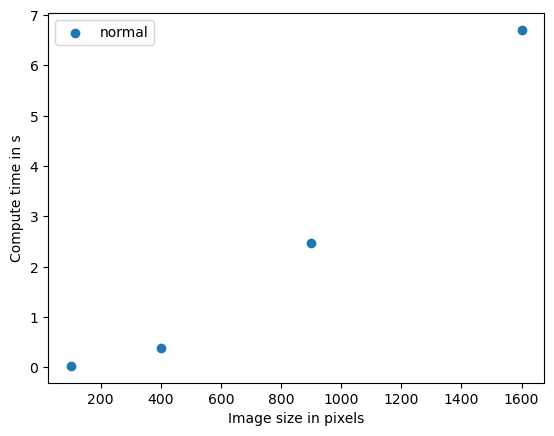

In [6]:
plt.scatter(benchmark_data_silly_sum[:,0] ** 2, benchmark_data_silly_sum[:,1])
plt.legend(["normal"])
plt.xlabel("Image size in pixels")
plt.ylabel("Compute time in s")
plt.show()

这个算法对图像大小的依赖性很强，图表显示出大约[二次](https://en.wikipedia.org/wiki/Time_complexity#Table_of_common_time_complexities)复杂度。这意味着如果数据大小翻倍，计算时间就会乘以四倍。该算法的大O表示法是`O(n^2)`。我们可以推测，在3D中应用类似的算法会有立方复杂度，即`O(n^3)`。如果这样的算法在你的科研中成为瓶颈，那么并行化和GPU加速就非常有意义。

## 使用numba进行代码优化
如果我们执行的代码很简单，只使用标准的Python、NumPy等函数，我们可以使用即时（JIT）编译器，例如[numba](https://numba.pydata.org/)提供的编译器来加速代码。

In [7]:
from numba import jit

@jit
def process_image_compiled(image):
    for x in range(image.shape[1]):
        for y in range(image.shape[1]):
            # Silly algorithm for wasting compute time
            sum = 0
            for i in range(1000):
                for j in range(1000):
                    sum = sum + x
                sum = sum + y
            image[x, y] = sum

In [8]:
%timeit process_image_compiled(image)

The slowest run took 56.00 times longer than the fastest. This could mean that an intermediate result is being cached.
2.84 µs ± 5.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
